In [466]:

import tensorflow as tf
from tensorflow.keras.preprocessing import image
import os
import random
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [467]:
# Paths to your dataset
train_dir = 'Dataset/Train'
test_dir = 'Dataset/Test'

In [468]:
# Define image size and batch size
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 64
MAX_TRAIN_IMAGES_PER_CLASS = 3000  
MAX_TEST_IMAGES_PER_CLASS = 1200  

In [469]:
# Function to load and sample images
def load_images_from_class(class_dir, max_images_per_class):
    # Get all image files in the class directory
    image_files = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]
    
    # Randomly sample up to `max_images_per_class` images
    sampled_images = random.sample(image_files, min(max_images_per_class, len(image_files)))
    
    images = []
    for img in sampled_images:
        img_path = os.path.join(class_dir, img)
        img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        img_array = image.img_to_array(img)
        images.append(img_array)
    
    return np.array(images), len(sampled_images)


In [470]:
# Function to prepare the dataset
def prepare_dataset(directory, max_images_per_class):
    class_names = os.listdir(directory)
    class_names = [name for name in class_names if os.path.isdir(os.path.join(directory, name))]
    
    all_images = []
    all_labels = []
    
    for class_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(directory, class_name)
        
        # Load the images from the class folder
        images, num_images = load_images_from_class(class_dir, max_images_per_class)
        
        # Add the images and labels to the lists
        all_images.append(images)
        all_labels.extend([class_idx] * num_images)  # Labels are the class indices
    
    # Concatenate all images and labels
    all_images = np.concatenate(all_images, axis=0)
    all_labels = np.array(all_labels)
    
    # One-hot encode the labels
    all_labels = to_categorical(all_labels, num_classes=len(class_names))
    
    return all_images, all_labels

In [471]:
# Load and prepare the train and test datasets
train_images, train_labels = prepare_dataset(train_dir, MAX_TRAIN_IMAGES_PER_CLASS)
test_images, test_labels = prepare_dataset(test_dir, MAX_TEST_IMAGES_PER_CLASS)


In [472]:
import numpy as np

# Define class names based on your dataset
CLASS_NAMES = ['Corrected', 'Normal', 'Reversal']  

# Convert one-hot encoded labels to class indices
train_class_indices = np.argmax(train_labels, axis=1)
test_class_indices = np.argmax(test_labels, axis=1)

# Count occurrences of each class
train_class_counts = {class_name: (train_class_indices == i).sum() for i, class_name in enumerate(CLASS_NAMES)}
test_class_counts = {class_name: (test_class_indices == i).sum() for i, class_name in enumerate(CLASS_NAMES)}

# Print the counts
print("Image counts in the Train dataset:")
for class_name, count in train_class_counts.items():
    print(f"{class_name}: {count}")

print("\nImage counts in the Test dataset:")
for class_name, count in test_class_counts.items():
    print(f"{class_name}: {count}")


Image counts in the Train dataset:
Corrected: 1000
Normal: 1000
Reversal: 972

Image counts in the Test dataset:
Corrected: 600
Normal: 630
Reversal: 1008


In [ ]:
# Split the train dataset if needed 
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

In [474]:
# Convert to TensorFlow datasets for better batching and shuffling
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(BATCH_SIZE)

In [475]:
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_dataset = test_dataset.batch(BATCH_SIZE)

In [476]:
# Build a CNN model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)), # Input Layer
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(np.unique(np.argmax(train_labels, axis=1))), activation='softmax')  # Output layer
])

c:\Users\AAYU\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [477]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [478]:
# Train the model
EPOCHS = 15

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS
)

Epoch 1/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 14s 333ms/step - accuracy: 0.6895 - loss: 33.6323 - val_accuracy: 0.9882 - val_loss: 0.0524
Epoch 2/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 320ms/step - accuracy: 0.9832 - loss: 0.0501 - val_accuracy: 1.0000 - val_loss: 0.0029
Epoch 3/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 352ms/step - accuracy: 0.9972 - loss: 0.0124 - val_accuracy: 1.0000 - val_loss: 0.0017
Epoch 4/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 332ms/step - accuracy: 0.9989 - loss: 0.0044 - val_accuracy: 0.9950 - val_loss: 0.0097
Epoch 5/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 326ms/step - accuracy: 0.9980 - loss: 0.0041 - val_accuracy: 0.9983 - val_loss: 0.0047
Epoch 6/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 322ms/step - accuracy: 0.9998 - loss: 0.0014 - val_accuracy: 0.9983 - val_loss: 0.0021
Epoch 7/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 324ms/step - accuracy: 0.9999 - loss: 0.0017 - val_accuracy: 1.0000 - val_loss: 3.7609e-04
Epoch 8/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 327ms/step - accuracy: 0.9995 - loss: 0.0024 - val

In [479]:
# Save the model
model.save('dyslexia_model.h5')

In [480]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.8686 - loss: 1.6012
Test Accuracy: 77.17%


In [481]:
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Assuming y_true (true labels) and y_pred (predicted labels) are available
# Replace them with the true and predicted labels from your test dataset
y_true = np.argmax(test_labels, axis=1)  # Convert one-hot encoded labels to class indices
y_pred = np.argmax(model.predict(test_dataset), axis=1)  # Model predictions

# Generate the classification report
report = classification_report(y_true, y_pred, target_names=CLASS_NAMES)

# Print classification report
print("Classification Report:")
print(report)

# Calculate and display overall accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Overall Accuracy: {accuracy * 100:.2f}%")


35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step
Classification Report:
              precision    recall  f1-score   support

   Corrected       0.59      0.88      0.70       600
      Normal       0.85      1.00      0.92       630
    Reversal       0.95      0.57      0.71      1008

    accuracy                           0.77      2238
   macro avg       0.80      0.81      0.78      2238
weighted avg       0.82      0.77      0.77      2238

Overall Accuracy: 77.17%


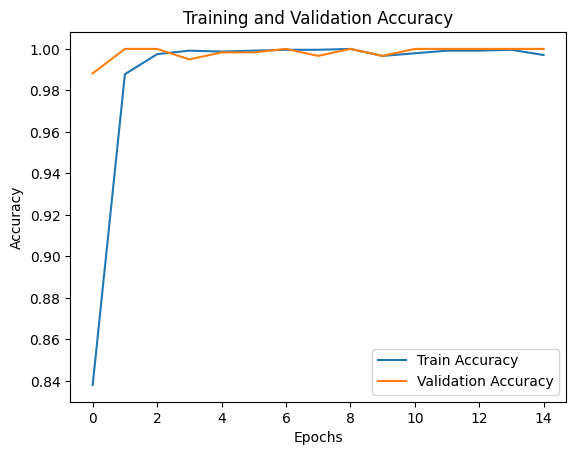

In [482]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

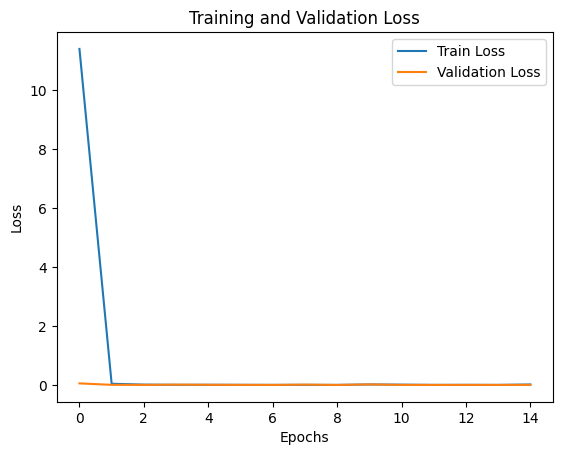

In [483]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step


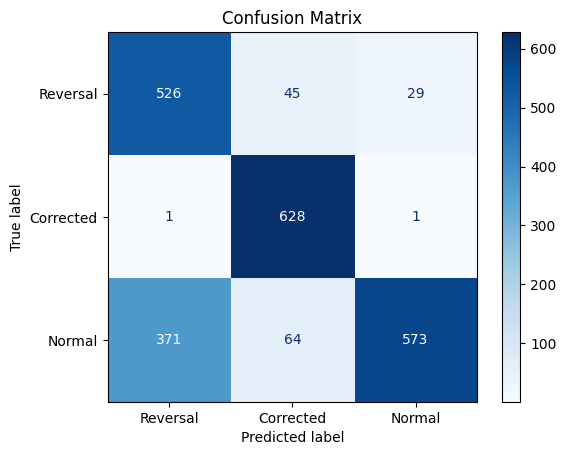

In [484]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Predict on the test dataset
y_pred = model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get the class with highest probability
y_true = np.argmax(test_labels, axis=1)  # True labels

# Compute confusion matrix
class_labels = ['Reversal', 'Corrected', 'Normal']
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

# Plot confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')

plt.show()

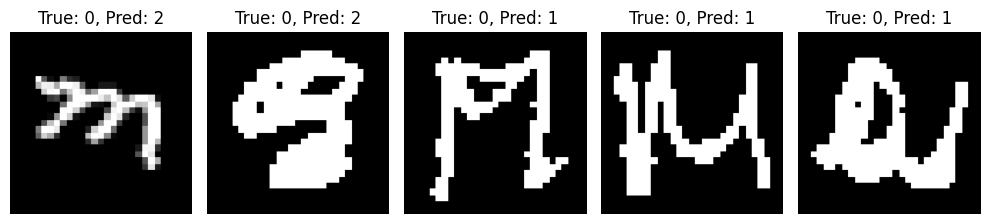

In [485]:
# Get misclassified indices
misclassified_indices = np.where(y_pred_classes != y_true)[0]

# Plot a few misclassified images
num_images_to_display = 5
plt.figure(figsize=(10, 10))
for i in range(num_images_to_display):
    index = misclassified_indices[i]
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(test_images[index].astype('uint8'))
    plt.title(f"True: {y_true[index]}, Pred: {y_pred_classes[index]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


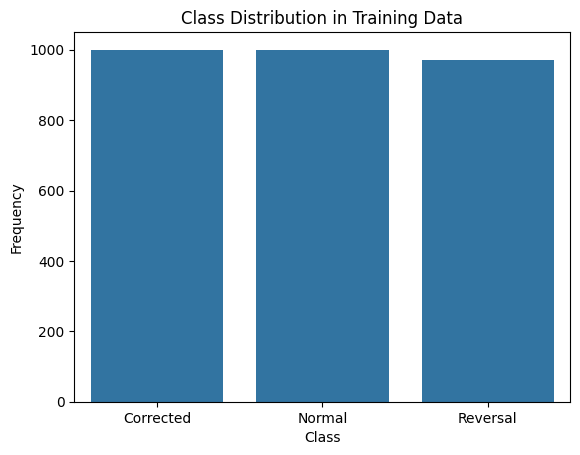

In [486]:
import seaborn as sns

# Compute class distribution
class_distribution = np.argmax(train_labels, axis=1)
sns.countplot(x=class_distribution)
plt.title('Class Distribution in Training Data')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(ticks=[0, 1, 2], labels=['Corrected', 'Normal', 'Reversal'])

plt.show()